For this project, I will be clustering NBA players from the 2018-2019 season. The data comes from Basketball Reference, and can be found [here](https://www.basketball-reference.com/leagues/NBA_2019_per_game.html).

In [1]:
from bs4 import BeautifulSoup
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats.mstats import winsorize
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from urllib.request import urlopen
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Getting the data

To get the data from basketball reference, I will scrape it using BeautifulSoup and save it into a dataframe.

In [2]:
url = "https://www.basketball-reference.com/leagues/NBA_2019_per_game.html"
html = urlopen(url)
soup = BeautifulSoup(html)

In [3]:
soup.findAll('tr', limit=2)
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
headers = headers[1:]
headers

['Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS']

In [4]:
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]

In [5]:
stats = pd.DataFrame(player_stats, columns = headers)
stats.head(50)

Player    Pos   Age    Tm     G    GS    MP    FG   FGA  \
0             Álex Abrines     SG    25   OKC    31     2  19.0   1.8   5.1   
1               Quincy Acy     PF    28   PHO    10     0  12.3   0.4   1.8   
2             Jaylen Adams     PG    22   ATL    34     1  12.6   1.1   3.2   
3             Steven Adams      C    25   OKC    80    80  33.4   6.0  10.1   
4              Bam Adebayo      C    21   MIA    82    28  23.3   3.4   5.9   
5                Deng Adel     SF    21   CLE    19     3  10.2   0.6   1.9   
6   DeVaughn Akoon-Purcell     SG    25   DEN     7     0   3.1   0.4   1.4   
7        LaMarcus Aldridge      C    33   SAS    81    81  33.2   8.4  16.3   
8             Rawle Alkins     SG    21   CHI    10     1  12.0   1.3   3.9   
9            Grayson Allen     SG    23   UTA    38     2  10.9   1.8   4.7   
10           Jarrett Allen      C    20   BRK    80    80  26.2   4.2   7.1   
11            Kadeem Allen     SG    26   NYK    19     1  21.9   3.4   7.4   
12         Al-Farouq Aminu     PF    28   POR    81    81  28.3   3.2   7.3   
13         Justin Anderson     SF    25   ATL    48     4   9.6   1.3   3.3   
14           Kyle Anderson     SF    25   MEM    43    40  29.8   3.5   6.4   
15           Ryan Anderson     PF    30   TOT    25     8  12.9   0.8   2.8   
16           Ryan Anderson     PF    30   PHO    15     8  18.5   1.3   4.0   
17           Ryan Anderson     PF    30   MIA    10     0   4.4   0.2   0.9   
18            Ike Anigbogu      C    20   IND     3     0   2.0   0.0   1.0   
19   Giannis Antetokounmpo     PF    24   MIL    72    72  32.8  10.0  17.3   
20    Kostas Antetokounmpo     PF    21   DAL     2     0   5.5   0.0   1.5   
21         Carmelo Anthony     PF    34   HOU    10     2  29.4   4.9  12.1   
22                    None   None  None  None  None  None  None  None  None   
23              OG Anunoby     SF    21   TOR    67     6  20.2   2.7   6.0   
24        Ryan Arcidiacono     PG    24   CHI    81    32  24.2   2.3   5.2   
25            Trevor Ariza     SF    33   TOT    69    69  34.0   4.3  10.7   
26            Trevor Ariza     SF    33   PHO    26    26  34.0   3.3   8.7   
27            Trevor Ariza     SF    33   WAS    43    43  34.1   4.8  11.8   
28           D.J. Augustin     PG    31   ORL    81    81  28.0   3.9   8.4   
29           Deandre Ayton      C    20   PHO    71    70  30.7   7.2  12.3   
30            Dwayne Bacon     SG    23   CHO    43    13  17.7   2.8   6.0   
31       Marvin Bagley III     PF    19   SAC    62     4  25.3   5.7  11.4   
32               Ron Baker     SG    25   TOT    15     0  10.1   0.3   1.3   
33               Ron Baker     SG    25   NYK    11     0   9.7   0.4   1.5   
34               Ron Baker     SG    25   WAS     4     0  11.3   0.0   1.0   
35            Wade Baldwin     PG    22   POR    16     0   5.9   0.6   2.1   
36              Lonzo Ball     PG    21   LAL    47    45  30.3   3.9   9.7   
37                Mo Bamba      C    20   ORL    47     1  16.3   2.5   5.2   
38              J.J. Barea     PG    34   DAL    38     0  19.8   4.2  10.1   
39         Harrison Barnes  PF-SF    26   TOT    77    77  32.9   5.6  13.3   
40         Harrison Barnes     PF    26   DAL    49    49  32.3   5.9  14.6   
41         Harrison Barnes     SF    26   SAC    28    28  33.9   5.0  11.1   
42             Will Barton     SF    28   DEN    43    38  27.7   4.3  10.7   
43        Keita Bates-Diop     SF    23   MIN    30     3  16.8   2.0   4.7   
44           Nicolas Batum     SF    30   CHO    75    72  31.4   3.4   7.5   
45          Jerryd Bayless     PG    30   MIN    34     6  19.3   2.4   6.8   
46             Aron Baynes      C    32   BOS    51    18  16.1   2.1   4.4   
47           Kent Bazemore     SG    29   ATL    67    35  24.5   4.1  10.3   
48            Bradley Beal     SG    25   WAS    82    82  36.9   9.3  19.6   
49                    None   None  None  None  None  None  None  None 

Now that the data is loaded into a dataframe, we can begin cleaning.

## Data cleaning

To begin cleaning, I will first check the data types and see if they are what I think they should be. If not, I will change them.

In [6]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 29 columns):
Player    708 non-null object
Pos       708 non-null object
Age       708 non-null object
Tm        708 non-null object
G         708 non-null object
GS        708 non-null object
MP        708 non-null object
FG        708 non-null object
FGA       708 non-null object
FG%       708 non-null object
3P        708 non-null object
3PA       708 non-null object
3P%       708 non-null object
2P        708 non-null object
2PA       708 non-null object
2P%       708 non-null object
eFG%      708 non-null object
FT        708 non-null object
FTA       708 non-null object
FT%       708 non-null object
ORB       708 non-null object
DRB       708 non-null object
TRB       708 non-null object
AST       708 non-null object
STL       708 non-null object
BLK       708 non-null object
TOV       708 non-null object
PF        708 non-null object
PTS       708 non-null object
dtypes: object(29)
memory

I think many of these columns should be numeric, rather than objects. I will convert them.

In [7]:
stats['Age'] = pd.to_numeric(stats['Age'], errors='coerce')
stats['G'] = pd.to_numeric(stats['G'], errors='coerce')
stats['GS'] = pd.to_numeric(stats['GS'], errors='coerce')
stats['MP'] = pd.to_numeric(stats['MP'], errors='coerce')
stats['FG'] = pd.to_numeric(stats['FG'], errors='coerce')
stats['FGA'] = pd.to_numeric(stats['FGA'], errors='coerce')
stats['FG%'] = pd.to_numeric(stats['FG%'], errors='coerce')
stats['3P'] = pd.to_numeric(stats['3P'], errors='coerce')
stats['3PA'] = pd.to_numeric(stats['3PA'], errors='coerce')
stats['3P%'] = pd.to_numeric(stats['3P%'], errors='coerce')
stats['2P'] = pd.to_numeric(stats['2P'], errors='coerce')
stats['2PA'] = pd.to_numeric(stats['2PA'], errors='coerce')
stats['2P%'] = pd.to_numeric(stats['2P%'], errors='coerce')
stats['eFG%'] = pd.to_numeric(stats['eFG%'], errors='coerce')
stats['FT'] = pd.to_numeric(stats['FT'], errors='coerce')
stats['FTA'] = pd.to_numeric(stats['FTA'], errors='coerce')
stats['FT%'] = pd.to_numeric(stats['FT%'], errors='coerce')
stats['ORB'] = pd.to_numeric(stats['ORB'], errors='coerce')
stats['DRB'] = pd.to_numeric(stats['DRB'], errors='coerce')
stats['TRB'] = pd.to_numeric(stats['TRB'], errors='coerce')
stats['AST'] = pd.to_numeric(stats['AST'], errors='coerce')
stats['STL'] = pd.to_numeric(stats['STL'], errors='coerce')
stats['BLK'] = pd.to_numeric(stats['BLK'], errors='coerce')
stats['TOV'] = pd.to_numeric(stats['TOV'], errors='coerce')
stats['PF'] = pd.to_numeric(stats['PF'], errors='coerce')
stats['PTS'] = pd.to_numeric(stats['PTS'], errors='coerce')

Now to check and clean null values.

In [8]:
Sum = stats.isnull().sum()
Percentage = (stats.isnull().sum()/stats.isnull().count()*100)

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

Sum  Percentage
Player   26    3.542234
Pos      26    3.542234
Age      26    3.542234
Tm       26    3.542234
G        26    3.542234
GS       26    3.542234
MP       26    3.542234
FG       26    3.542234
FGA      26    3.542234
FG%      32    4.359673
3P       26    3.542234
3PA      26    3.542234
3P%      73    9.945504
2P       26    3.542234
2PA      26    3.542234
2P%      41    5.585831
eFG%     32    4.359673
FT       26    3.542234
FTA      26    3.542234
FT%      69    9.400545
ORB      26    3.542234
DRB      26    3.542234
TRB      26    3.542234
AST      26    3.542234
STL      26    3.542234
BLK      26    3.542234
TOV      26    3.542234
PF       26    3.542234
PTS      26    3.542234

Many of the nulls are causes by a row header in the original data table in the basketball reference website. I will remove those.

In [9]:
stats = stats[stats['Player'].notna()]

In [10]:
Sum = stats.isnull().sum()
Percentage = (stats.isnull().sum()/stats.isnull().count()*100)

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

Sum  Percentage
Player    0    0.000000
Pos       0    0.000000
Age       0    0.000000
Tm        0    0.000000
G         0    0.000000
GS        0    0.000000
MP        0    0.000000
FG        0    0.000000
FGA       0    0.000000
FG%       6    0.847458
3P        0    0.000000
3PA       0    0.000000
3P%      47    6.638418
2P        0    0.000000
2PA       0    0.000000
2P%      15    2.118644
eFG%      6    0.847458
FT        0    0.000000
FTA       0    0.000000
FT%      43    6.073446
ORB       0    0.000000
DRB       0    0.000000
TRB       0    0.000000
AST       0    0.000000
STL       0    0.000000
BLK       0    0.000000
TOV       0    0.000000
PF        0    0.000000
PTS       0    0.000000

Now the nulls are caused by there being no value in the percentage column for some players, due to them taking 0 attempts of certain shots. I will impute a 0 and finish null cleaning.

In [11]:
stats.fillna(0,inplace=True)

To finish cleaning, I will remove the "TOT" category from the data and filter out players who have played less than 30 games.

In [12]:
stats = stats[stats['Tm'] != 'TOT']

In [13]:
cleanstats = stats[stats.G > 30]

## Data exploration

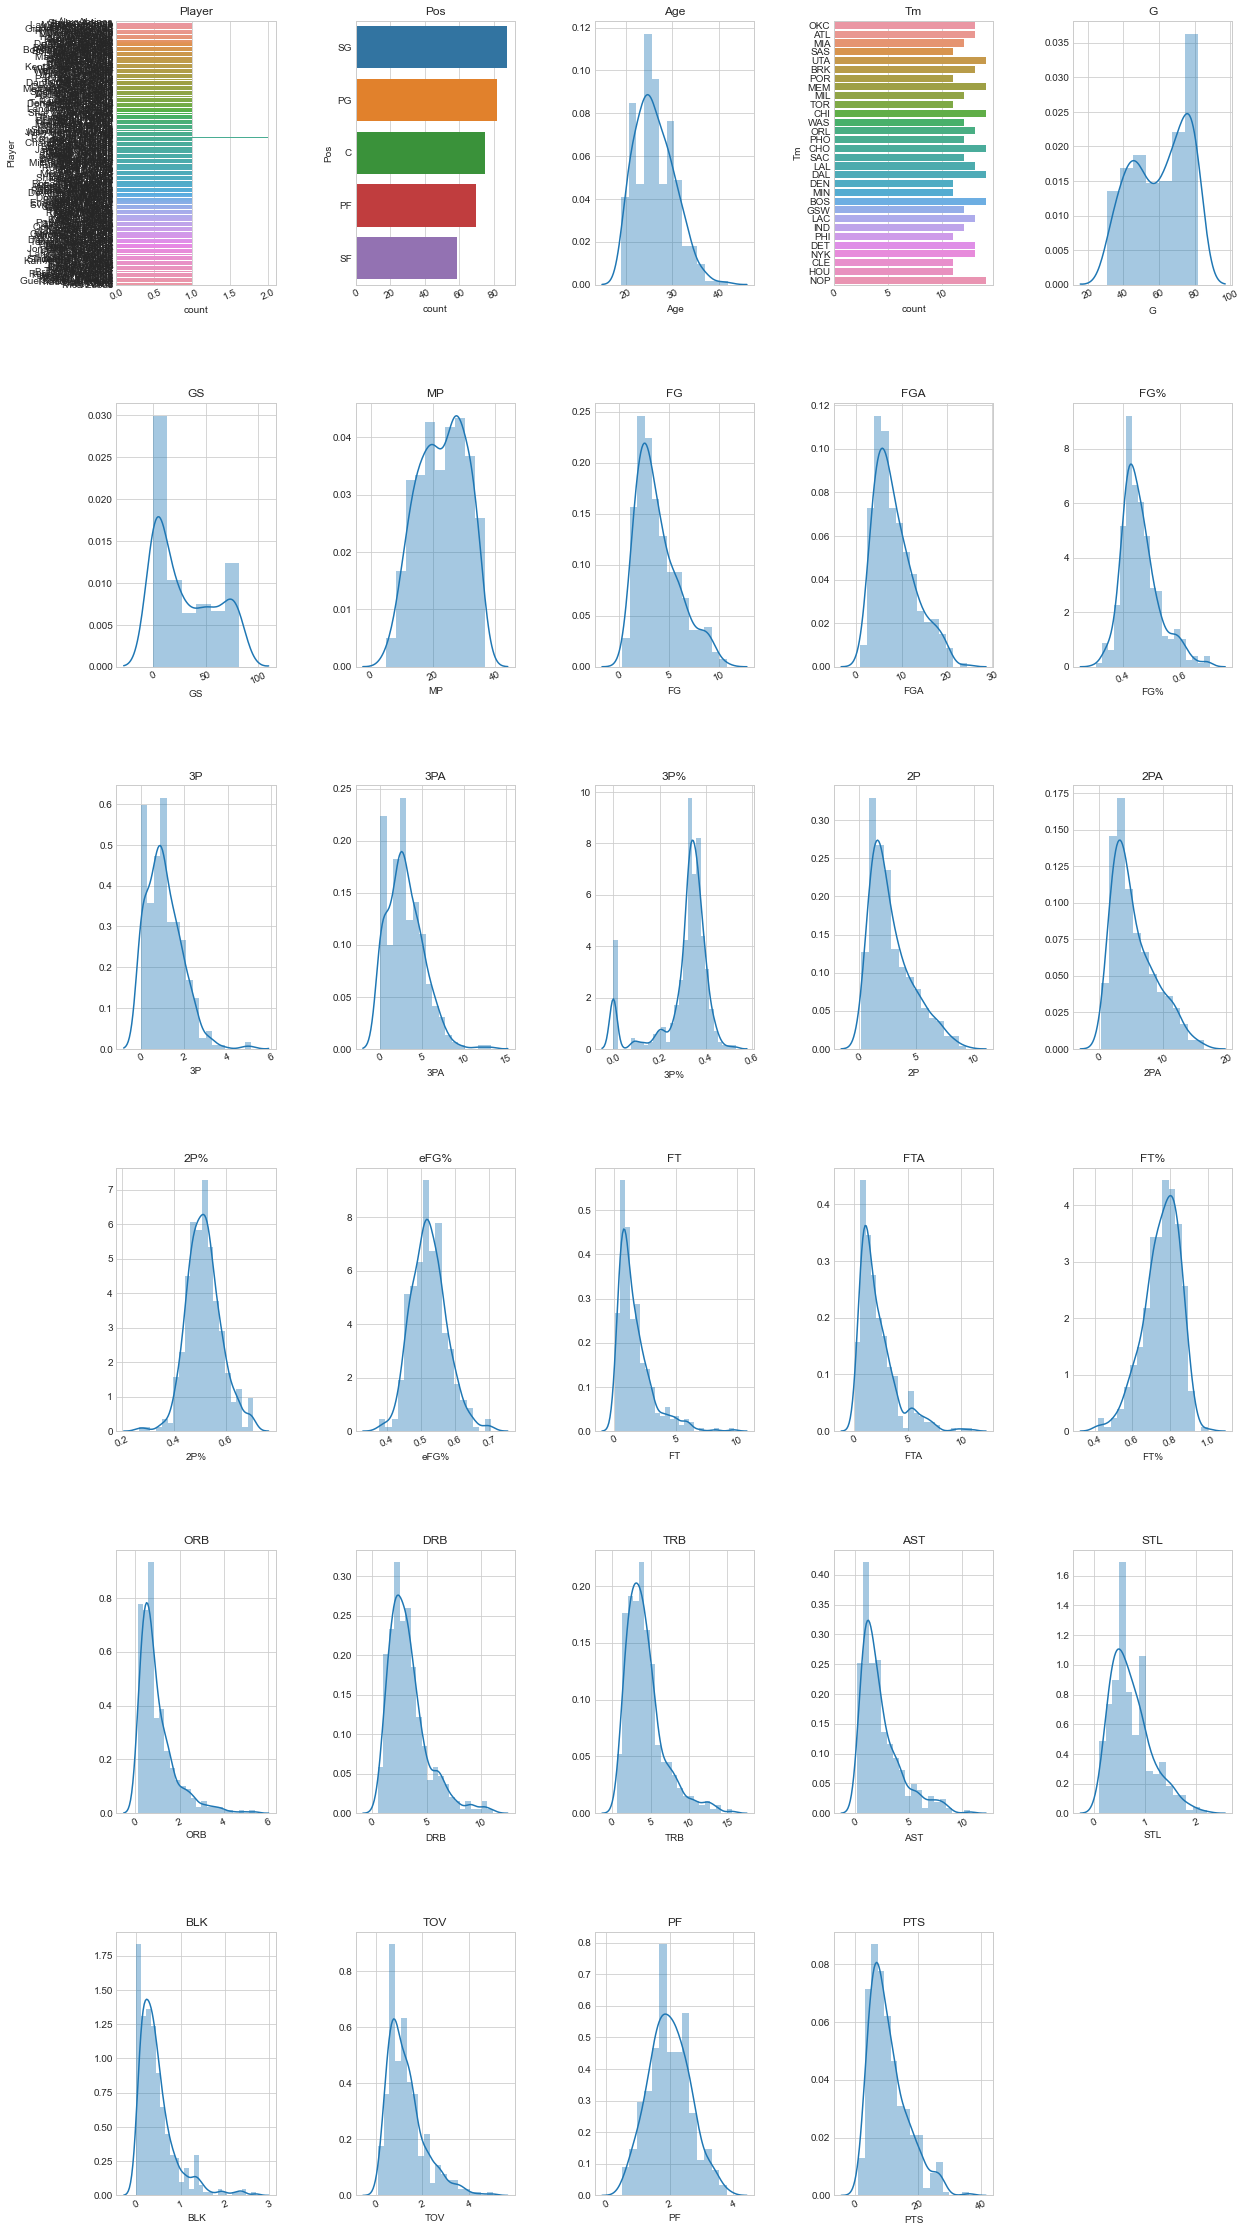

In [14]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(cleanstats, cols=5, width=20, height=40, hspace=0.45, wspace=0.5)

## PCA

To start PCA, first I will choose which features I want to be considered beforehand.

In [15]:
features = cleanstats.drop(['Player','Tm','Pos','Age','G','GS'], axis=1)

In [16]:
X=features
scaler = StandardScaler()
X_std = StandardScaler().fit_transform(X)

In [17]:
Xt = X.T
Cx = np.cov(Xt)

In [18]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

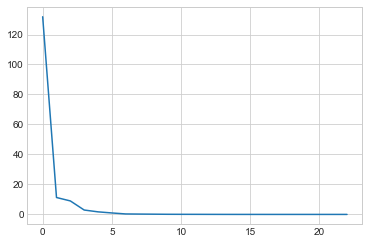

[1.31843150e+02 1.12785915e+01 8.99514697e+00 2.93217612e+00
 1.71223421e+00 9.74877845e-01 3.15187758e-01 2.28318434e-01
 1.61787611e-01 8.81395892e-02 6.43916419e-02 5.34128825e-02
 3.28803453e-02 1.77166795e-02 6.77403812e-03 3.17328106e-03
 2.19598164e-03 8.34640983e-05 4.15694146e-04 8.28227010e-04
 7.33035949e-04 6.63645333e-04 6.74268475e-04]


In [19]:
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

5 eigenvalues are higher than 0, which tells me my number of components.

In [20]:
pca = PCA(n_components=5)
pca.fit(X_std)

X_pca = pca.transform(X_std)

## UMAP

In [21]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(features)

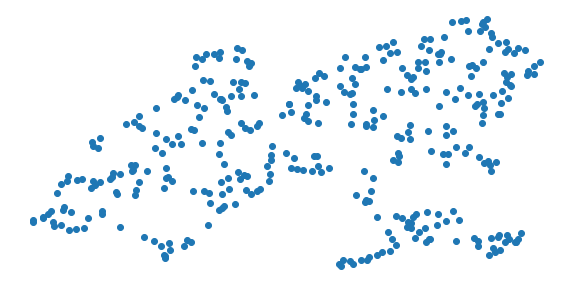

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

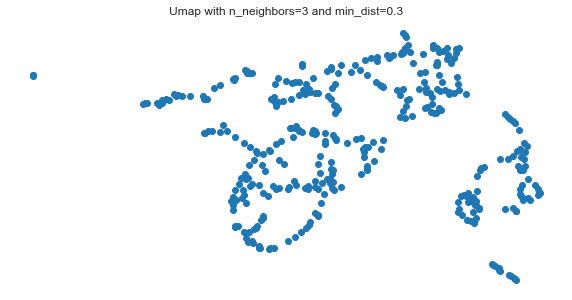

In [23]:
umap_results = umap.UMAP(n_neighbors=3,
                      min_dist=0.3,
                      metric='correlation').fit_transform(features)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=3 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

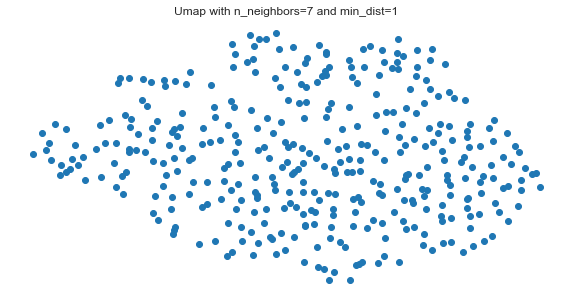

In [24]:
umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=1,
                      metric='correlation').fit_transform(features)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=1")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

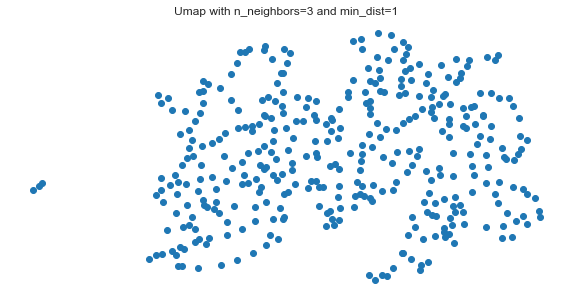

In [25]:
umap_results = umap.UMAP(n_neighbors=3,
                      min_dist=1,
                      metric='correlation').fit_transform(features)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=3 and min_dist=1")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

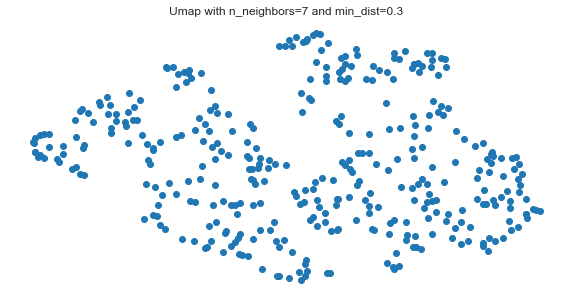

In [26]:
umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(features)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

I don't see clear regions using UMAP, so I will stick with PCA.

## Models

## K-Means

My first step is to find out how many clusters to choose from. To do that, I will look at an elbow curve and read silhouette scores.

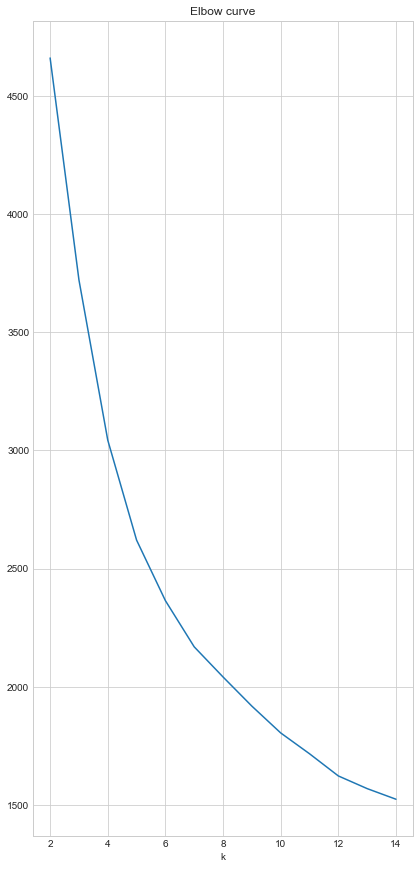

In [27]:
X = X_pca
y = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    y.append(kmeans.inertia_)

plt.figure(figsize=(15,15))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(2, 15), y)
plt.grid(True)

In [28]:
x = X_pca
silhouette = []

for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 99)
    cluster_labels = kmeans.fit_predict(x)
    
    centers = kmeans.cluster_centers_

    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.34864902181162444
For n_clusters = 3, silhouette score is 0.3402993316952551
For n_clusters = 4, silhouette score is 0.2836916385537665
For n_clusters = 5, silhouette score is 0.2618485334788448
For n_clusters = 6, silhouette score is 0.2331009282852517
For n_clusters = 7, silhouette score is 0.202334684934278
For n_clusters = 8, silhouette score is 0.2187135251832992
For n_clusters = 9, silhouette score is 0.20616723878465087
For n_clusters = 10, silhouette score is 0.20088581666372096
For n_clusters = 11, silhouette score is 0.20833303867332487
For n_clusters = 12, silhouette score is 0.19602612015817927
For n_clusters = 13, silhouette score is 0.2037579241984917
For n_clusters = 14, silhouette score is 0.1967827910260329
For n_clusters = 15, silhouette score is 0.19220323115722338
For n_clusters = 16, silhouette score is 0.20360712254701474
For n_clusters = 17, silhouette score is 0.18911449851649617
For n_clusters = 18, silhouette score is 

In [29]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1 - silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print("For n_cluster = {}, percent improvement = {}".format(i + 2, improvement))

For n_cluster = 3, percent improvement = -0.012819033663836077
For n_cluster = 4, percent improvement = -0.08580814884871257
For n_cluster = 5, percent improvement = -0.030493997069670264
For n_cluster = 6, percent improvement = -0.03894540144867298
For n_cluster = 7, percent improvement = -0.04011772146520132
For n_cluster = 8, percent improvement = 0.020533474302655064
For n_cluster = 9, percent improvement = -0.016058496854936433
For n_cluster = 10, percent improvement = -0.006653066463072399
For n_cluster = 11, percent improvement = 0.009319346552594032
For n_cluster = 12, percent improvement = -0.015545575496193065
For n_cluster = 13, percent improvement = 0.009616984126192829
For n_cluster = 14, percent improvement = -0.008760066045790715
For n_cluster = 15, percent improvement = -0.005701521104931828
For n_cluster = 16, percent improvement = 0.01411727779764238
For n_cluster = 17, percent improvement = -0.018197832302152994
For n_cluster = 18, percent improvement = 0.00341031757

My number of clusters will be eight.

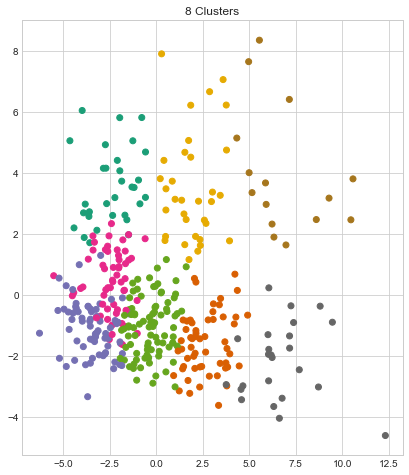

In [30]:
kmeans8 = KMeans(n_clusters=8, random_state=6).fit_predict(X_pca)

plt.figure(figsize=(15,8))
plt.subplot(121, title='8 Clusters')
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans8, cmap='Dark2')

## GMM

In [31]:
x = X_pca
silhouette2 = []

for i in range(2, 21):
    gmm_cluster = GaussianMixture(n_components=i, random_state=123)
    clusters = gmm_cluster.fit_predict(x)
    print("Silhouette score: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Silhouette score: 0.2939485795592999
Silhouette score: 0.12829952325660002
Silhouette score: 0.17229016429084215
Silhouette score: 0.14574089957761197
Silhouette score: 0.10312912665660444
Silhouette score: 0.10099977064515218
Silhouette score: 0.09988789480024754
Silhouette score: 0.10558420651780163
Silhouette score: 0.09122615215829667
Silhouette score: 0.09478391100226145
Silhouette score: 0.06537315150408768
Silhouette score: 0.06586794262715016
Silhouette score: 0.0732888268758371
Silhouette score: 0.07558681782152947
Silhouette score: 0.06748131890394178
Silhouette score: 0.06217634029107333
Silhouette score: 0.053908325376756314
Silhouette score: 0.06362378948755577
Silhouette score: 0.047396495875684536


In [32]:
gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type="full")

clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=full: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type="tied")

clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=tied: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type="diag")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=diag: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")


gmm_cluster = GaussianMixture(n_components=3, random_state=123, covariance_type="spherical")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=spherical: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

Silhouette score with covariance_type=full: 0.15679269941234653
------------------------------------------------------
Silhouette score with covariance_type=tied: 0.16266041467669287
------------------------------------------------------
Silhouette score with covariance_type=diag: 0.14106887654721537
------------------------------------------------------
Silhouette score with covariance_type=spherical: 0.18027666742631854
------------------------------------------------------


GMM has a lower silhouette score than K-means.

## Hierarchical Clustering

To begin hierachical clustering, I'll first make dendrograms of 3 different linking methods.

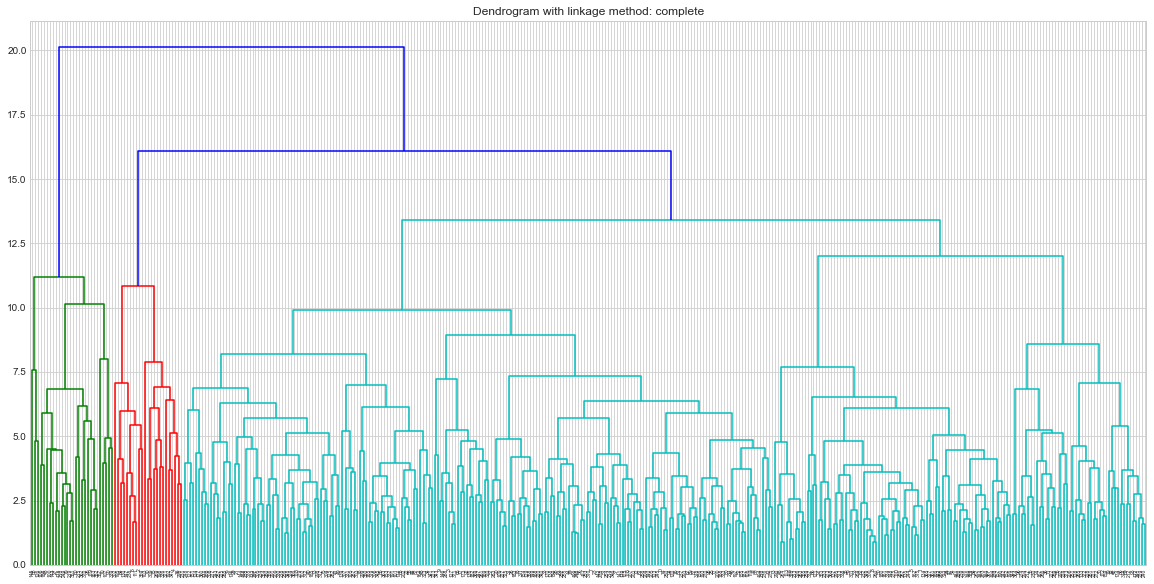

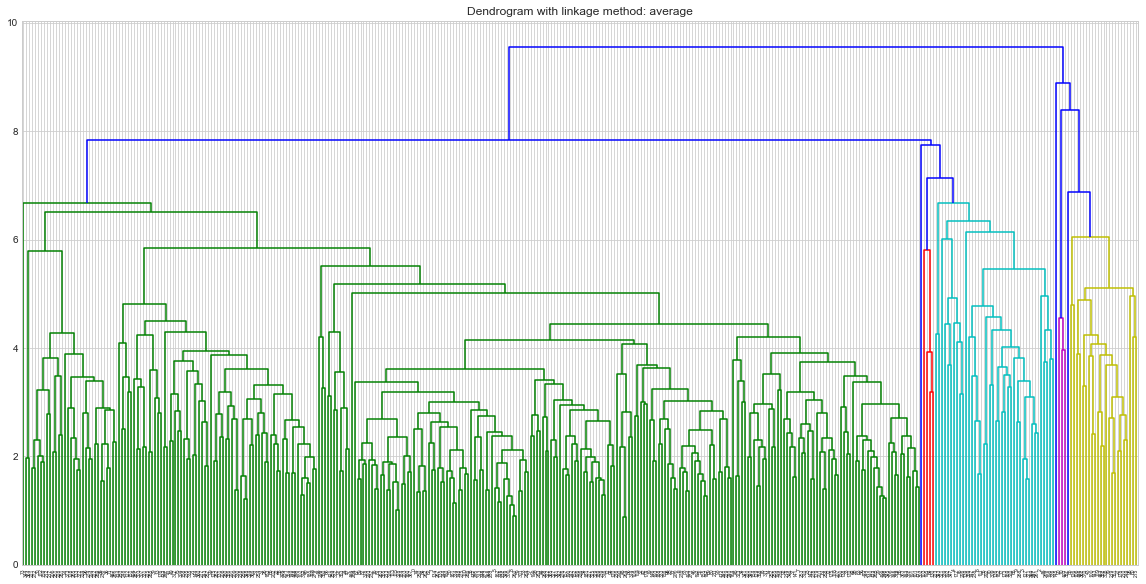

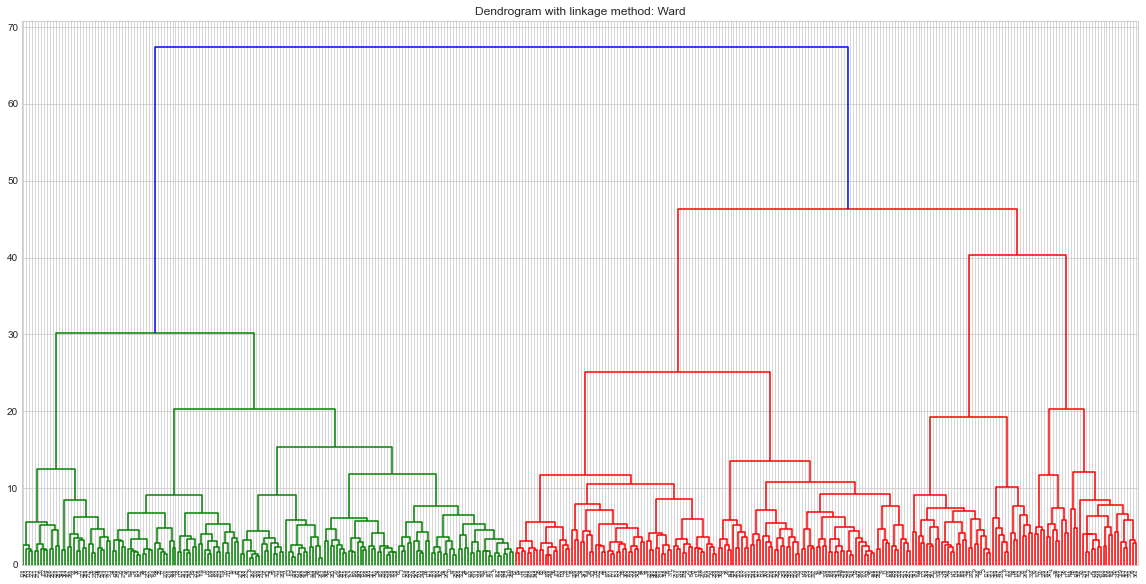

In [33]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

I don't like how the average method has clusters that are very small. I'll use the complete method and ward method and compare their silhouette scores to k-means.

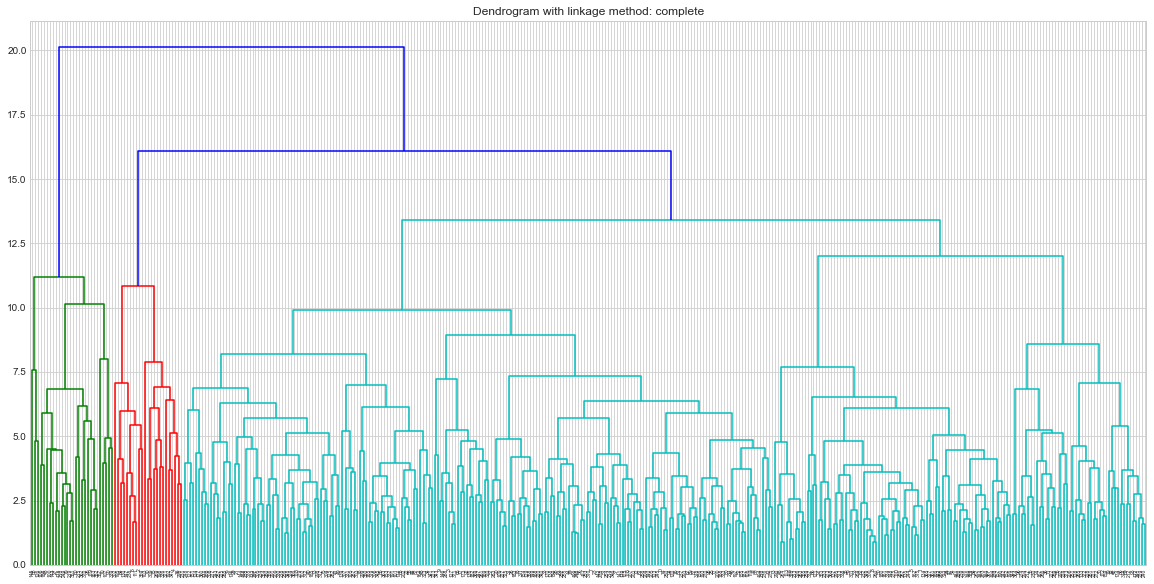

In [34]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

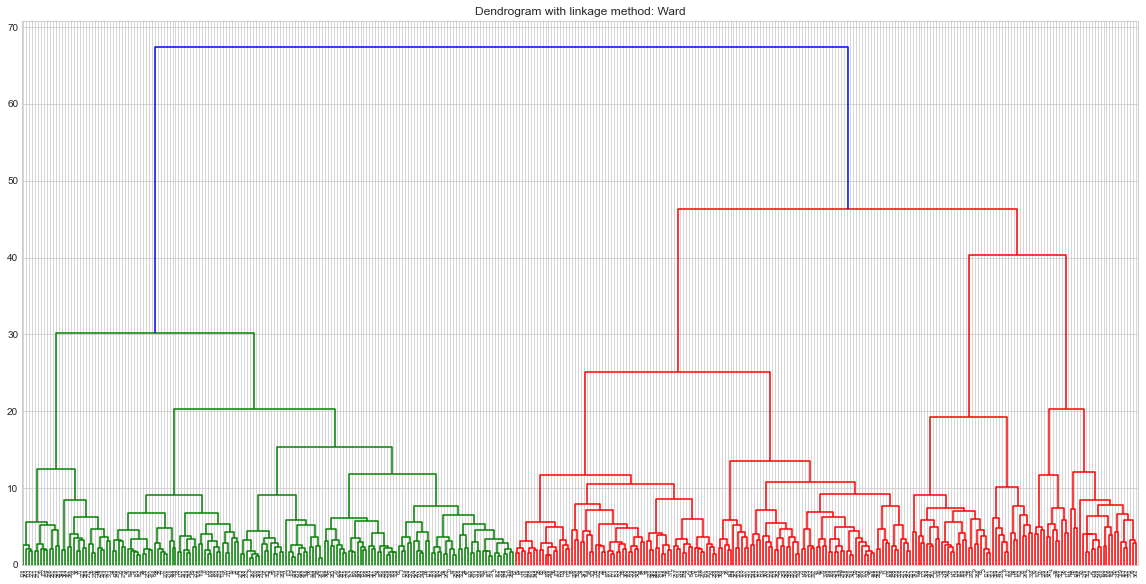

In [35]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

In [36]:
linkage_methods = ["ward", "average", "complete"]

agg_cluster = AgglomerativeClustering(linkage="complete", 
                                      affinity='cosine',
                                      n_clusters=6)

clusters = agg_cluster.fit_predict(X_pca)

print("Silhouette score of linkage method complete: {}".format(
    metrics.silhouette_score(X_pca, clusters, metric='euclidean')))
print("------------------------------------------------")

agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=5)

hclusters = agg_cluster.fit_predict(X_pca)

print("Silhouette score of linkage method ward: {}".format(
    metrics.silhouette_score(X_pca, hclusters, metric='euclidean')))

Silhouette score of linkage method complete: 0.1405051065759467
------------------------------------------------
Silhouette score of linkage method ward: 0.20800965079419484


Both methods have a lower silhouette score than k-means (although ward method comes close).

The data after k-means clustering:

In [37]:
df_cluster = pd.DataFrame()
df_cluster = cleanstats.copy()
df_cluster['Cluster'] = kmeans8

df_cluster.head(25)

Player Pos   Age   Tm     G    GS    MP    FG   FGA    FG%  \
0            Álex Abrines  SG  25.0  OKC  31.0   2.0  19.0   1.8   5.1  0.357   
2            Jaylen Adams  PG  22.0  ATL  34.0   1.0  12.6   1.1   3.2  0.345   
3            Steven Adams   C  25.0  OKC  80.0  80.0  33.4   6.0  10.1  0.595   
4             Bam Adebayo   C  21.0  MIA  82.0  28.0  23.3   3.4   5.9  0.576   
7       LaMarcus Aldridge   C  33.0  SAS  81.0  81.0  33.2   8.4  16.3  0.519   
9           Grayson Allen  SG  23.0  UTA  38.0   2.0  10.9   1.8   4.7  0.376   
10          Jarrett Allen   C  20.0  BRK  80.0  80.0  26.2   4.2   7.1  0.590   
12        Al-Farouq Aminu  PF  28.0  POR  81.0  81.0  28.3   3.2   7.3  0.433   
13        Justin Anderson  SF  25.0  ATL  48.0   4.0   9.6   1.3   3.3  0.408   
14          Kyle Anderson  SF  25.0  MEM  43.0  40.0  29.8   3.5   6.4  0.543   
19  Giannis Antetokounmpo  PF  24.0  MIL  72.0  72.0  32.8  10.0  17.3  0.578   
23             OG Anunoby  SF  21.0  TOR  67.0   6.0  20.2   2.7   6.0  0.453   
24       Ryan Arcidiacono  PG  24.0  CHI  81.0  32.0  24.2   2.3   5.2  0.447   
27           Trevor Ariza  SF  33.0  WAS  43.0  43.0  34.1   4.8  11.8  0.409   
28          D.J. Augustin  PG  31.0  ORL  81.0  81.0  28.0   3.9   8.4  0.470   
29          Deandre Ayton   C  20.0  PHO  71.0  70.0  30.7   7.2  12.3  0.585   
30           Dwayne Bacon  SG  23.0  CHO  43.0  13.0  17.7   2.8   6.0  0.475   
31      Marvin Bagley III  PF  19.0  SAC  62.0   4.0  25.3   5.7  11.4  0.504   
36             Lonzo Ball  PG  21.0  LAL  47.0  45.0  30.3   3.9   9.7  0.406   
37               Mo Bamba   C  20.0  ORL  47.0   1.0  16.3   2.5   5.2  0.481   
38             J.J. Barea  PG  34.0  DAL  38.0   0.0  19.8   4.2  10.1  0.418   
40        Harrison Barnes  PF  26.0  DAL  49.0  49.0  32.3   5.9  14.6  0.404   
42            Will Barton  SF  28.0  DEN  43.0  38.0  27.7   4.3  10.7  0.402   
44          Nicolas Batum  SF  30.0  CHO  75.0  72.0  31.4   3.4   7.5  0.450   
45         Jerryd Bayless  PG  30.0  MIN  34.0   6.0  19.3   2.4   6.8  0.357   

    ...  ORB   DRB   TRB  AST  STL  BLK  TOV   PF   PTS  Cluster  
0   ...  0.2   1.4   1.5  0.6  0.5  0.2  0.5  1.7   5.3        2  
2   ...  0.3   1.4   1.8  1.9  0.4  0.1  0.8  1.3   3.2        2  
3   ...  4.9   4.6   9.5  1.6  1.5  1.0  1.7  2.6  13.9        5  
4   ...  2.0   5.3   7.3  2.2  0.9  0.8  1.5  2.5   8.9        5  
7   ...  3.1   6.1   9.2  2.4  0.5  1.3  1.8  2.2  21.3        6  
9   ...  0.1   0.5   0.6  0.7  0.2  0.2  0.9  1.2   5.6        2  
10  ...  2.4   6.0   8.4  1.4  0.5  1.5  1.3  2.3  10.9        5  
12  ...  1.4   6.1   7.5  1.3  0.8  0.4  0.9  1.8   9.4        4  
13  ...  0.5   1.3   1.8  0.5  0.5  0.3  0.5  1.0   3.7        2  
14  ...  1.1   4.7   5.8  3.0  1.3  0.9  1.3  2.6   8.0        5  
19  ...  2.2  10.3  12.5  5.9  1.3  1.5  3.7  3.2  27.7        6  
23  ...  0.9   2.1   2.9  0.7  0.7  0.3  0.8  2.1   7.0        3  
24  ...  0.3   2.4   2.7  3.3  0.8  0.0  0.8  2.1   6.7        3  
27  ...  0.8   4.5   5.3  3.8  1.2  0.3  1.6  2.0  14.1        1  
28  ...  0.5   2.0   2.5  5.3  0.6  0.0  1.6  1.4  11.7        4  
29  ...  3.1   7.1  10.3  1.8  0.9  0.9  1.8  2.9  16.3        6  
30  ...  0.2   1.9   2.1  1.1  0.3  0.1  0.4  1.7   7.3        3  
31  ...  2.6   5.0   7.6  1.0  0.5  1.0  1.6  1.9  14.9        5  
36  ...  1.1   4.2   5.3  5.4  1.5  0.4  2.2  2.4   9.9        4  
37  ...  1.4   3.6   5.0  0.8  0.3  1.4  0.9  2.2   6.2        0  
38  ...  0.3   2.2   2.5  5.6  0.6  0.0  1.9  1.3  10.9        4  
40  ...  0.7   3.5   4.2  1.3  0.7  0.2  1.4  1.6  17.7        1  
42  ...  0.7   3.9   4.6  2.9  0.4  0.5  1.5  1.9  11.5        4  
44  ...  0.9   4.3   5.2  3.3  0.9  0.6  1.6  1.9   9.3        4  
45  ...  0.3   1.5   1.8  3.5  0.5  0.1  0.9  1.6   6.1        2  

[25 rows x 30 columns]

## Identifying Clusters

To begin identifying and naming the clusters, I will first give them a placeholder name and compare their means to the mean of the original dataset.

In [38]:
cluster1 = df_cluster.loc[df_cluster['Cluster'] == 0]
cluster2 = df_cluster.loc[df_cluster['Cluster'] == 1]
cluster3 = df_cluster.loc[df_cluster['Cluster'] == 2]
cluster4 = df_cluster.loc[df_cluster['Cluster'] == 3]
cluster5 = df_cluster.loc[df_cluster['Cluster'] == 4]
cluster6 = df_cluster.loc[df_cluster['Cluster'] == 5]
cluster7 = df_cluster.loc[df_cluster['Cluster'] == 6]
cluster8 = df_cluster.loc[df_cluster['Cluster'] == 7]

In [39]:
cleanstats.mean()

Age     26.267380
G       60.751337
GS      30.719251
MP      23.005615
FG       3.885829
FGA      8.461230
FG%      0.459853
3P       1.075668
3PA      3.037701
3P%      0.309634
2P       2.809358
2PA      5.425936
2P%      0.515112
eFG%     0.523390
FT       1.667380
FTA      2.177807
FT%      0.755230
ORB      0.971123
DRB      3.287166
TRB      4.252406
AST      2.378075
STL      0.724599
BLK      0.470053
TOV      1.296257
PF       1.989572
PTS     10.514171
dtype: float64

In [40]:
mm = cleanstats.mean()

In [41]:
AA = cluster1.mean()

In [42]:
BB = cluster2.mean()

In [43]:
CC = cluster3.mean()

In [44]:
DD = cluster4.mean()

In [45]:
EE = cluster5.mean()

In [46]:
FF = cluster6.mean()

In [47]:
GG = cluster7.mean()

In [48]:
HH = cluster8.mean()

In [49]:
AA-mm

2P         -0.674983
2P%         0.067013
2PA        -1.697811
3P         -1.019418
3P%        -0.233165
3PA        -2.818951
AST        -1.487450
Age        -0.017380
BLK         0.151822
Cluster          NaN
DRB        -0.477791
FG         -1.695204
FG%         0.103335
FGA        -4.517480
FT         -0.742380
FT%        -0.090980
FTA        -0.815307
G          -6.126337
GS        -21.719251
MP         -9.052490
ORB         0.416377
PF         -0.202072
PTS        -5.132921
STL        -0.377724
TOV        -0.558757
TRB        -0.046156
eFG%        0.046766
dtype: float64

In [50]:
BB-mm

2P          1.219213
2P%        -0.022202
2PA         2.759778
3P          0.758260
3P%         0.051563
3PA         2.001585
AST         1.257639
Age         0.304049
BLK        -0.091482
Cluster          NaN
DRB         0.541406
FG          1.967743
FG%        -0.017192
FGA         4.754841
FT          0.868335
FT%         0.050627
FTA         0.965050
G           2.141520
GS         19.709320
MP          7.547956
ORB        -0.185409
PF          0.238999
PTS         5.557257
STL         0.225401
TOV         0.593029
TRB         0.352951
eFG%       -0.011355
dtype: float64

In [51]:
CC-mm

2P         -1.638770
2P%        -0.054053
2PA        -2.868583
3P         -0.366845
3P%         0.003307
3PA        -0.858289
AST        -0.908957
Age        -0.399733
BLK        -0.274465
Cluster          NaN
DRB        -1.718048
FG         -2.003476
FG%        -0.061338
FGA        -3.736230
FT         -0.952674
FT%         0.009623
FTA        -1.246925
G         -11.192513
GS        -24.969251
MP         -8.308556
ORB        -0.600535
PF         -0.630749
PTS        -5.328877
STL        -0.293717
TOV        -0.590374
TRB        -2.331818
eFG%       -0.049626
dtype: float64

In [52]:
DD-mm

2P         -1.323393
2P%         0.039203
2PA        -2.720673
3P         -0.223037
3P%         0.046928
3PA        -0.707876
AST        -1.183338
Age         0.346655
BLK        -0.131457
Cluster          NaN
DRB        -0.906464
FG         -1.536706
FG%         0.008112
FGA        -3.422633
FT         -0.911239
FT%        -0.015739
FTA        -1.140965
G          -0.382916
GS        -19.017497
MP         -5.145966
ORB        -0.232527
PF         -0.250976
PTS        -4.214171
STL        -0.212318
TOV        -0.634853
TRB        -1.143634
eFG%        0.027189
dtype: float64

In [53]:
EE-mm

2P        -0.609358
2P%       -0.029404
2PA       -0.865262
3P         0.296242
3P%        0.041861
3PA        0.792637
AST        0.109566
Age        0.373070
BLK       -0.079042
Cluster         NaN
DRB       -0.208514
FG        -0.311672
FG%       -0.033527
FGA       -0.070219
FT        -0.360638
FT%        0.013894
FTA       -0.486796
G          1.787989
GS         3.123445
MP         2.542700
ORB       -0.273370
PF         0.069978
PTS       -0.683834
STL        0.114727
TOV       -0.034459
TRB       -0.479373
eFG%      -0.015053
dtype: float64

In [54]:
FF-mm

2P          1.505793
2P%         0.071282
2PA         1.946791
3P         -0.660517
3P%        -0.043725
3PA        -1.813458
AST        -0.529590
Age        -0.752228
BLK         0.608734
Cluster          NaN
DRB         1.961319
FG          0.835383
FG%         0.093208
FGA         0.138770
FT          0.287166
FT%        -0.060957
FTA         0.661586
G           7.885027
GS         17.795900
MP          3.030749
ORB         1.350089
PF          0.713458
PTS         1.294920
STL         0.090553
TOV         0.094652
TRB         3.311230
eFG%        0.052670
dtype: float64

In [55]:
GG-mm

2P          4.443975
2P%         0.061288
2PA         7.234064
3P         -0.495668
3P%        -0.101434
3PA        -1.217701
AST         1.155258
Age        -1.867380
BLK         0.883280
Cluster          NaN
DRB         4.939501
FG          3.954171
FG%         0.089147
FGA         6.018770
FT          2.552620
FT%        -0.015563
FTA         3.502193
G          12.115330
GS         40.280749
MP          9.014385
ORB         2.235544
PF          0.963761
PTS         9.965829
STL         0.275401
TOV         1.157077
TRB         7.194260
eFG%        0.043476
dtype: float64

In [56]:
HH-mm

2P          3.253142
2P%        -0.004779
2PA         6.424064
3P          1.278498
3P%         0.038033
3PA         3.516466
AST         4.034425
Age         0.440954
BLK         0.004947
Cluster          NaN
DRB         1.383668
FG          4.530838
FG%        -0.002686
FGA         9.951270
FT          3.174287
FT%         0.055312
FTA         3.784693
G          10.748663
GS         37.655749
MP         10.990218
ORB        -0.108623
PF          0.252094
PTS        13.510829
STL         0.592068
TOV         1.816243
TRB         1.289260
eFG%       -0.003599
dtype: float64

After looking at the mean differences and the plots below, I made a name for each cluster that describes the players within them. 

In [57]:
cluster_names = ['BackupBigmen', 'SolidOutside', 'BenchPlayers', 'RotationalPlayers','GoodOutside','SolidBigmen','EliteBigmen','AllAroundElites']

cluster_dict = dict(zip(list(range(0, 10)), cluster_names))

In [58]:
cluster_dict

{0: 'BackupBigmen',
 1: 'SolidOutside',
 2: 'BenchPlayers',
 3: 'RotationalPlayers',
 4: 'GoodOutside',
 5: 'SolidBigmen',
 6: 'EliteBigmen',
 7: 'AllAroundElites'}

And now to apply the names to the clusters.

In [59]:
df_cluster['Cluster'] = df_cluster.Cluster.replace(cluster_dict)

In [60]:
df_cluster.head(50)

Player Pos   Age   Tm     G    GS    MP    FG   FGA    FG%  \
0            Álex Abrines  SG  25.0  OKC  31.0   2.0  19.0   1.8   5.1  0.357   
2            Jaylen Adams  PG  22.0  ATL  34.0   1.0  12.6   1.1   3.2  0.345   
3            Steven Adams   C  25.0  OKC  80.0  80.0  33.4   6.0  10.1  0.595   
4             Bam Adebayo   C  21.0  MIA  82.0  28.0  23.3   3.4   5.9  0.576   
7       LaMarcus Aldridge   C  33.0  SAS  81.0  81.0  33.2   8.4  16.3  0.519   
9           Grayson Allen  SG  23.0  UTA  38.0   2.0  10.9   1.8   4.7  0.376   
10          Jarrett Allen   C  20.0  BRK  80.0  80.0  26.2   4.2   7.1  0.590   
12        Al-Farouq Aminu  PF  28.0  POR  81.0  81.0  28.3   3.2   7.3  0.433   
13        Justin Anderson  SF  25.0  ATL  48.0   4.0   9.6   1.3   3.3  0.408   
14          Kyle Anderson  SF  25.0  MEM  43.0  40.0  29.8   3.5   6.4  0.543   
19  Giannis Antetokounmpo  PF  24.0  MIL  72.0  72.0  32.8  10.0  17.3  0.578   
23             OG Anunoby  SF  21.0  TOR  67.0   6.0  20.2   2.7   6.0  0.453   
24       Ryan Arcidiacono  PG  24.0  CHI  81.0  32.0  24.2   2.3   5.2  0.447   
27           Trevor Ariza  SF  33.0  WAS  43.0  43.0  34.1   4.8  11.8  0.409   
28          D.J. Augustin  PG  31.0  ORL  81.0  81.0  28.0   3.9   8.4  0.470   
29          Deandre Ayton   C  20.0  PHO  71.0  70.0  30.7   7.2  12.3  0.585   
30           Dwayne Bacon  SG  23.0  CHO  43.0  13.0  17.7   2.8   6.0  0.475   
31      Marvin Bagley III  PF  19.0  SAC  62.0   4.0  25.3   5.7  11.4  0.504   
36             Lonzo Ball  PG  21.0  LAL  47.0  45.0  30.3   3.9   9.7  0.406   
37               Mo Bamba   C  20.0  ORL  47.0   1.0  16.3   2.5   5.2  0.481   
38             J.J. Barea  PG  34.0  DAL  38.0   0.0  19.8   4.2  10.1  0.418   
40        Harrison Barnes  PF  26.0  DAL  49.0  49.0  32.3   5.9  14.6  0.404   
42            Will Barton  SF  28.0  DEN  43.0  38.0  27.7   4.3  10.7  0.402   
44          Nicolas Batum  SF  30.0  CHO  75.0  72.0  31.4   3.4   7.5  0.450   
45         Jerryd Bayless  PG  30.0  MIN  34.0   6.0  19.3   2.4   6.8  0.357   
46            Aron Baynes   C  32.0  BOS  51.0  18.0  16.1   2.1   4.4  0.471   
47          Kent Bazemore  SG  29.0  ATL  67.0  35.0  24.5   4.1  10.3  0.402   
48           Bradley Beal  SG  25.0  WAS  82.0  82.0  36.9   9.3  19.6  0.475   
50          Malik Beasley  SG  22.0  DEN  81.0  18.0  23.2   4.3   9.1  0.474   
52        Marco Belinelli  SG  32.0  SAS  79.0   1.0  23.0   3.6   8.7  0.413   
53            Jordan Bell   C  24.0  GSW  68.0   3.0  11.6   1.5   2.8  0.516   
54        DeAndre' Bembry  SG  24.0  ATL  82.0  15.0  23.5   3.4   7.5  0.446   
55          Dragan Bender  PF  21.0  PHO  46.0  27.0  18.0   1.9   4.3  0.447   
57          Dāvis Bertāns  PF  26.0  SAS  76.0  12.0  21.5   2.7   6.0  0.450   
58       Patrick Beverley  PG  30.0  LAC  78.0  49.0  27.4   2.5   6.1  0.407   
59             Khem Birch   C  26.0  ORL  50.0   1.0  12.9   1.8   3.0  0.603   
60        Bismack Biyombo   C  26.0  CHO  54.0  32.0  14.5   1.6   2.9  0.571   
61        Nemanja Bjelica  PF  30.0  SAC  77.0  70.0  23.2   3.7   7.7  0.479   
62       Antonio Blakeney  SG  22.0  CHI  57.0   3.0  14.5   2.9   6.9  0.419   
63           Eric Bledsoe  PG  29.0  MIL  78.0  78.0  29.1   6.0  12.4  0.484   
65      Bogdan Bogdanović  SG  26.0  SAC  70.0  17.0  27.8   5.2  12.3  0.418   
66       Bojan Bogdanović  SF  29.0  IND  81.0  81.0  31.8   6.4  13.0  0.497   
68           Jonah Bolden  PF  23.0  PHI  44.0  10.0  14.5   1.8   3.7  0.494   
71           Devin Booker  SG  22.0  PHO  64.0  64.0  35.0   9.2  19.6  0.467   
74          Avery Bradley  SG  28.0  LAC  49.0  49.0  29.9   3.3   8.6  0.383   
80          Mikal Bridges  SF  22.0  PHO  82.0  56.0  29.5   3.0   6.9  0.430   
81          Miles Bridges  SF  20.0  CHO  80.0  25.0  21.2   3.0   6.4  0.464   
82         Isaiah Briscoe  PG  22.0  ORL  39.0   0.0  14.3   1.4   3.5  0.399   
83         Ryan Broekhoff  SG  28.0  DAL  42.0   0

## Plots used

In [61]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="PTS", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [62]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="AST", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [63]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="FG%", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [64]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="3P", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [65]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="BLK", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [66]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="STL", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [67]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="3P", y="STL", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [68]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="PTS", y="STL", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [69]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="Pos", y="MP", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [70]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="TRB", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [71]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="TOV", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [72]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="eFG%", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [73]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="ORB", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [74]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="TRB", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [75]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="G", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [76]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="G", y="GS", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

In [77]:
import plotly.express as px
df = df_cluster
fig = px.scatter(df, x="MP", y="GS", color="Cluster", hover_data=['Player'], color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

## Conclusion

I've taken NBA players from the 2018-2019 season and clustered them using 8 clusters.

Some things I might try if I redid this experiment:
- Find more advanced stats (the stats I used were fairly basic).
- Include players from different years.